# [LAB-10] 9. 일원분산분석 (2)
- 목표: 10-8에서 이해한 코드 작성을 적용해서 세 집단 간 차이를 보는 것
- 일원분산분석: 명목형변수 1개, 이원분산분석: 명목형변수 2개

## 분산분석 패키지 비교:

| 지원 항목 \ 패키지 종류 | SciPy | Statsmodels | Pingouin |
| ----------------- | ----- | ----------- | -------- |
| ANOVA 종류: | One-way ANOVA, Welch ANOVA | One-way ANOVA를 공식테이블 형태로 (공식 ANOVA 테이블) | One-way ANOVA, Welch ANOVA |
| 사후검정(Post-hoc) 종류: | 없음 | Tukey HSD (`pairwise_tukeyhsd`) | Tukey HSD, Games-Howell, Bonferroni 등 최다 지원 |
| 등분산성 위반 시 처리법 (Welch): | Welch ANOVA | 이분산 보정옵션 (`anova_lm(..., robust='hc3')` 등) | `welch_anova` 함수 |
| 비모수 대안(Kruskal, Friedman): | Kruskal, Mann-Whitney | 있음 | Kruskal, Friedman |
| 결과표의 가독성: | 않좋음(수치만 제공) | 좋음(SS, MS, df, F등을 담은 표 형태) | 제일 좋음(효과크기, CI, 사후검정결과 등 실무 중심의 표 제공) |

## 추천 프로세스:
`pingouin` 패키지 -> 일원분산분석 수행 -> anova (if 등분산성 충족 x: welch_anova로 ㄱㄱ)

## #01. 준비작업

### 1. 패키지 참조:

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리:
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리:
from pingouin import anova, welch_anova

# 사후검정을 위한 라이브러리:
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기:

데이터 정보: 식당 고객의 결제금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등이 담긴 기본 정보

목표: 금토일 요일 별 평균 팁이 차이 있는지 검정!

In [3]:
origin = load_data('tips')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/tips.xlsx
[desc] 식당 고객의 결제 금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등 기본 정보를 담은 데이터 분석·시각화 실습용 샘플 데이터 (출처: https://www.kaggle.com/datasets/sakshisatre/tips-dataset)

field       description
----------  -------------
total_bill  총 결제 금액
tip         팁 금액
sex         성별
smoker      흡연 여부
day         방문 요일
time        방문 시간대
size        일행 규모


===== 데이터 크기 확인 =====
데이터셋 크기: (244, 7)
열 갯수: 7
행 갯수: 244

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### 4. 데이터 전처리 - 금/토/일 데이터만 추출하기:

In [4]:
df = origin.query("day == 'Fri' or day == 'Sat' or day == 'Sun'")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## #02. 데이터 분포 및 가정 확인

### 1. 데이터 분포 확인:

요일별 팁 분포 KDE subplots로 화긴 ㄱㄱ

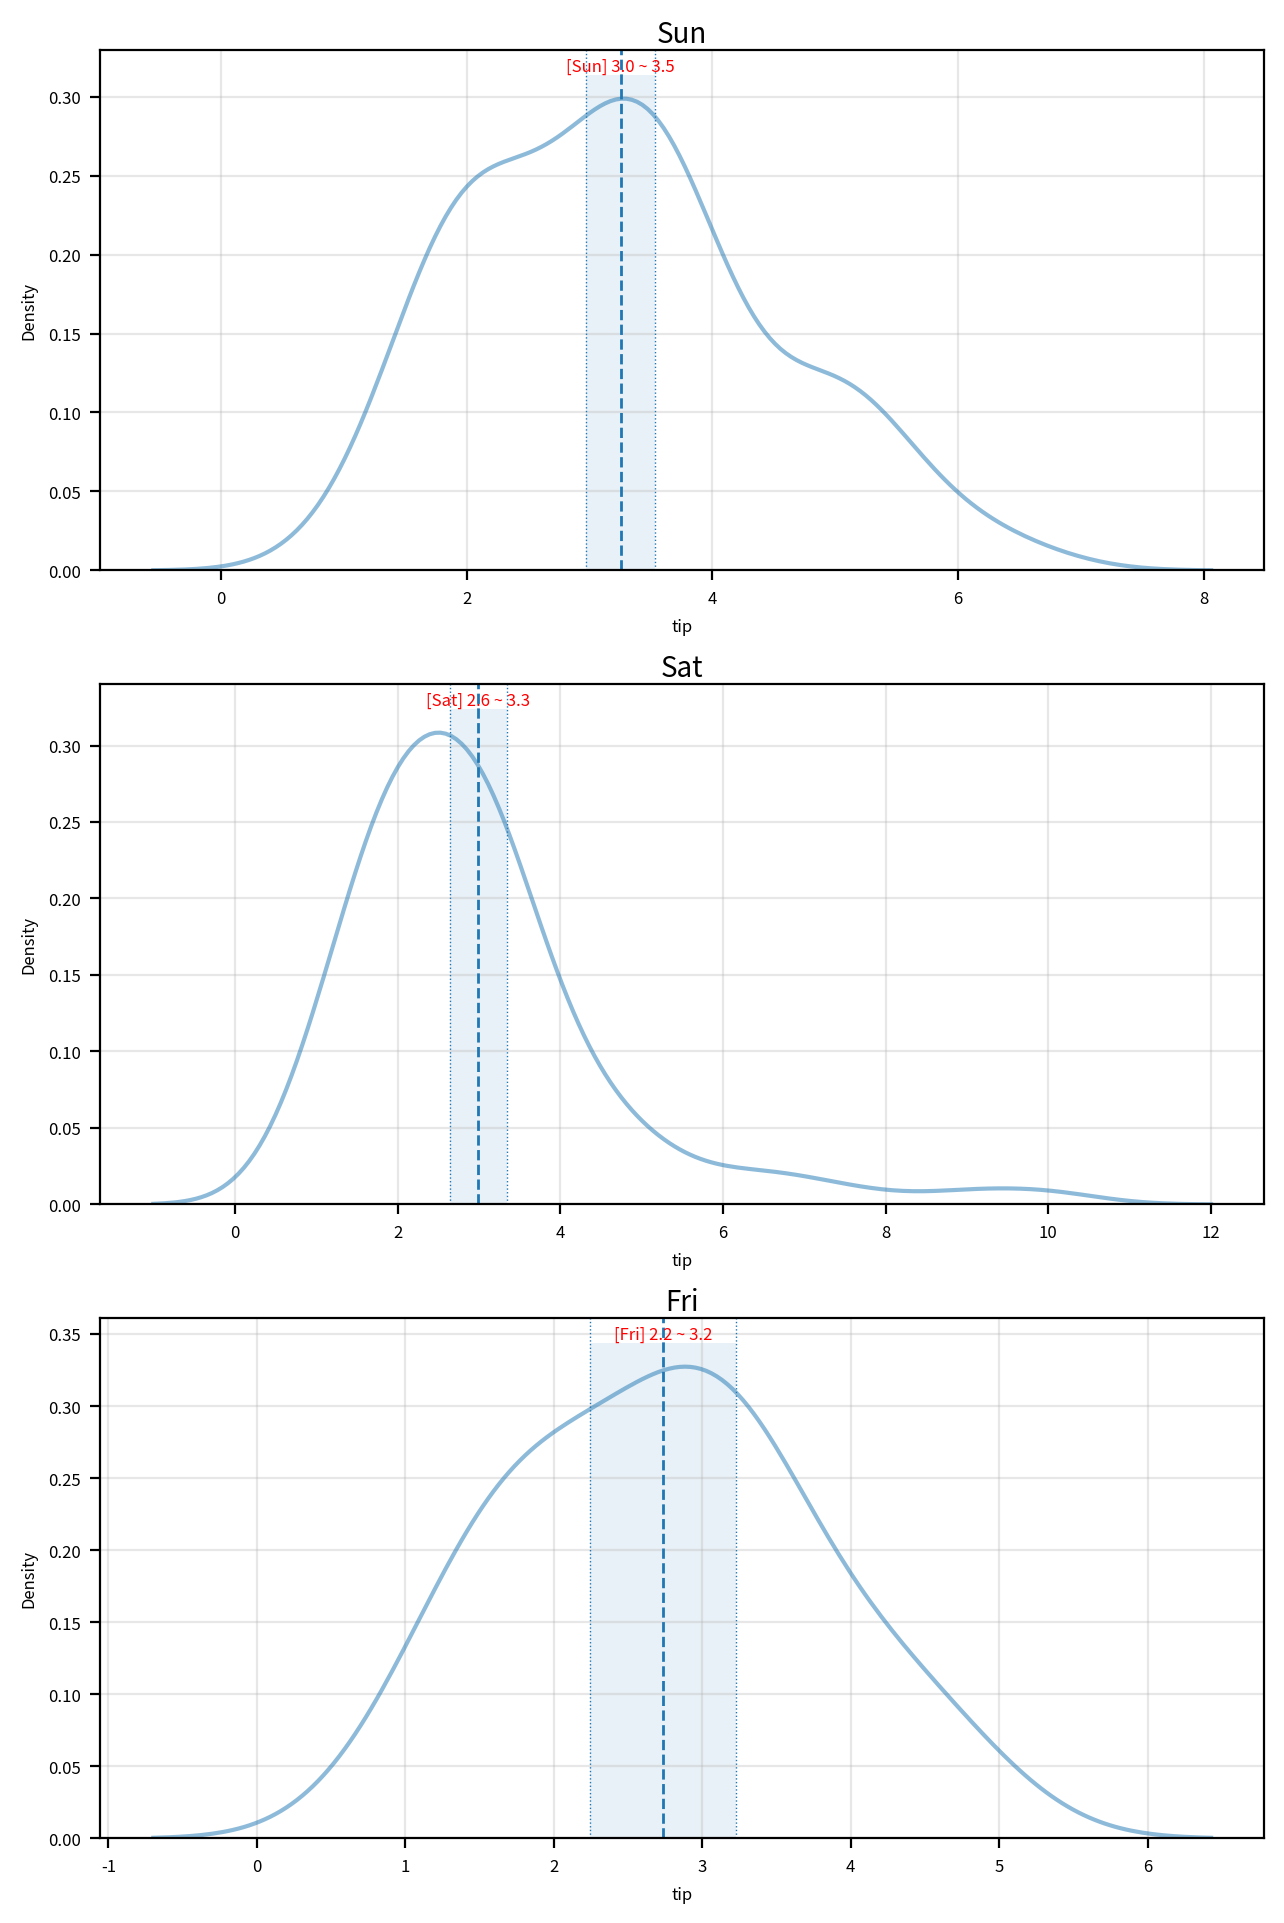

In [5]:
# 확인할 데이터 필드:
field = 'tip'

# 집단 구분용 필드 (hue)
hue_field = 'day'

# 요일 종류: 
hue_values = df[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 640 * 3         # 그래프 세로 크기
rows = 3                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, v in enumerate(hue_values):
    temp = df[df[hue_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, fill=False, ax = ax[i], alpha=0.5)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간용 기본변수:
    max = temp[field].max()                        # 최대값
    dof = len(temp[field]) - 1                     # 자유도
    clevel = 0.95                                  # 신뢰수준
    sp_mean = temp[field].mean()                   # 표본평균
    sp_std = temp[field].std(ddof=1) # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 신뢰구간 y값, 평균표시:
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기 (statAnnotator 기능):
    ax[i].text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

**인사이트:**

1. 형태: 모든 요일에서 KDE가 완만한 종 모양, 오른쪽 꼬리가 약간 김(right-skewed)
2. 요일별 평균:
   - 셋 다 평균이 peak보다 약간 오른쪽에 위치
   - `Sun > Sat > Fri` 순으로 평균 팁 높음
3. 신뢰구간(CI) 폭:
   - 팁 금액 변동성은 주말이 큼 (금요일이 비교적 안정적이고 팁 낮음)
     - Sun과 Sat은 넓은 폭 -> 변동성 큼
     - Fri는 좁은 폭 -> 금액이 비교적 일정

### 2. 정규성, 등분산성 검정

In [7]:
# 요일 별 그룹 생성:
groups = [(name, grp['tip']) for name, grp in df.groupby('day')]
# ↑: pivot table (리스트, 2차월 배열 같은) 만든거임 
    # grping 된 data들
    # ex) [(금, [a, b, c, ..]), (토, [m,n,o,..]), (일, [..])]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "fields": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok

# 등분산성 검정법 선택:
    # 정규성 충족할 때 등분산성 검정방법:
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups]) # 모든 컬럼의 데이터 한번에
# 정규성 충족 못할 때 등분산성 검정법:
else:
    test_name = "Levene's"
    stat, p = levene(*[s.values for _, s in groups], 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
Fri,0.416676,8.119325e-01,True
Sat,49.144308,2.130341e-11,False
Sun,3.396232,1.830280e-01,True
Levene's,0.651391,5.225516e-01,True


**정규성 위배가 ANOVA 불가를 의미하는건 아님!**

## #03. 일원분산분석 수행

표

### 1. 분석에 필요한 데이터만 추출하기:

In [8]:
# long-form 데이터
anova_df = origin[['tip', 'day']].copy()
anova_df

,tip,day
0,1.01,Sun
1,1.66,Sun
2,3.50,Sun
3,3.31,Sun
4,3.61,Sun
...,...,...
239,5.92,Sat
240,2.00,Sat
241,2.00,Sat
242,1.75,Sat


### 2. pingouin 패키지 사용 for 평균차 확인:

In [9]:
if equal_var: # : 만약 등분산성 충족하면
    pg_anova = anova(data=anova_df, dv='tip', between='day')
else: # : 만약 등분산성 충족 못하면
    pg_anova = welch_anova(data=anova_df, dv='tip', between='day')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,day,3,240,1.672355,0.173589,0.020476


In [11]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val<=0.05 else "귀무")

'statistic: 1.672, p-value: 0.174, 귀무가설 채택'

**인사이트:**
- 

## #05. 사후검정 (post hoc)

- if 등분산성 충족: Tukey HSD,
- else: Games-Howell 사용 ㄱㄱ
- (참고) 위에서 이미 귀무가설 채택이라는 결론이 나긴 했지만, 과정을 보여주기 위해서 코드 아래에 전개한거임 

In [12]:
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='tip', between='day')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=anova_df, dv='tip', between='day')

hoc_df

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Fri,Sat,2.734737,2.993103,-0.258367,0.348935,-0.740444,0.880645,-0.166274
1,Fri,Sun,2.734737,3.255132,-0.520395,0.353432,-1.472405,0.455805,-0.431509
2,Fri,Thur,2.734737,2.771452,-0.036715,0.361324,-0.101612,0.999623,-0.030468
3,Sat,Sun,2.993103,3.255132,-0.262028,0.216349,-1.211136,0.620382,-0.178644
4,Sat,Thur,2.993103,2.771452,0.221652,0.229016,0.967846,0.767858,0.148857
5,Sun,Thur,3.255132,2.771452,0.483680,0.235811,2.051132,0.172421,0.388762


**인사이트:**

> 1. 모든 요일 쌍에서 p-tukey > 0.05로 나타나, Fri·Sat·Sun·Thur 간 평균 팁 금액의 유의한 차이는 발견되지 않았다.
> 2. Fri와 Sat, Fri와 Sun, Fri와 Thur 비교에서 평균 차이가 존재하더라도 통계적으로 유의하지 않았으며, 이는 표본 내 자연스러운 변동 범위로 볼 수 있다.
> 3. Sat과 Sun 비교에서도 Sat이 약간 낮은 경향(diff = -0.26)이 있으나, p=0.620 으로 차이가 유의하지 않다.
> 4. Sun과 Thur 비교는 diff=0.48로 가장 큰 평균 차이가 있었지만(p=0.172) 통계적 기준을 충족하지 못해 유의한 차이라고 볼 수 없다.